# Data Audit - Stock data

Let's start off with the financial data containing Apple's stock price that we obtained using the Barchart API. Let's grab the data we put in BigQuery. Since it's not much, we can grab all of it. 

In [43]:
import google.cloud.bigquery as bq
import pandas as pd

client = bq.Client()
sql = """
    SELECT * FROM `test-project-datalab-225214.AAPL.stocks`
"""
stock_data = client.query(sql).to_dataframe()

print("There are {} rows.".format(len(stock_data)))
stock_data.head()


There are 109 rows.


,volume,timestamp,symbol,high,tradingDay,low,close,openInterest,open
0,24796300,2019-03-07 05:00:00+00:00,AAPL,174.44,2019-03-07,172.02,172.50,None,173.87
1,23999300,2019-03-08 05:00:00+00:00,AAPL,173.07,2019-03-08,169.50,172.91,None,170.32
2,32011000,2019-03-11 04:00:00+00:00,AAPL,179.12,2019-03-11,175.35,178.90,None,175.49
3,32467500,2019-03-12 04:00:00+00:00,AAPL,182.67,2019-03-12,179.37,180.91,None,180.00
4,31032500,2019-03-13 04:00:00+00:00,AAPL,183.30,2019-03-13,180.92,181.71,None,182.25


In [49]:
# looking at the type of each field
stock_data.dtypes

volume                        int64
timestamp       datetime64[ns, UTC]
symbol                       object
high                        float64
tradingDay                   object
low                         float64
close                       float64
openInterest                 object
open                        float64
dtype: object

Let's see what the Null/None values are

In [44]:
stock_data.isna().sum()

volume            0
timestamp         0
symbol            0
high              0
tradingDay        0
low               0
close             0
openInterest    109
open              0
dtype: int64

It looks like openInterest field is always None. We can get rid of this field. The other fields are okay.

In [67]:
df = stock_data.copy(deep=True)
df.drop('openInterest', axis=1, inplace=True)


In [68]:
df.describe()

,volume,high,low,close,open
count,1.090000e+02,109.000000,109.000000,109.000000,109.000000
mean,3.044456e+07,189.009220,185.391560,187.481651,187.136055
std,9.290900e+06,6.767808,6.465837,6.518023,6.806789
min,1.852660e+07,173.070000,169.500000,172.500000,170.320000
25%,2.356390e+07,184.100000,182.560000,183.730000,183.900000
50%,2.984840e+07,189.760000,186.550000,188.470000,188.950000
75%,3.246750e+07,194.460000,189.810000,191.240000,191.640000
max,5.103420e+07,197.690000,195.930000,197.000000,196.450000


In [69]:
#making sure to use the timestamp as index
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.index = df["timestamp"]
del df["timestamp"]
df.head()

,volume,symbol,high,tradingDay,low,close,open
timestamp,,,,,,,
2019-03-07 05:00:00+00:00,24796300,AAPL,174.44,2019-03-07,172.02,172.50,173.87
2019-03-08 05:00:00+00:00,23999300,AAPL,173.07,2019-03-08,169.50,172.91,170.32
2019-03-11 04:00:00+00:00,32011000,AAPL,179.12,2019-03-11,175.35,178.90,175.49
2019-03-12 04:00:00+00:00,32467500,AAPL,182.67,2019-03-12,179.37,180.91,180.00
2019-03-13 04:00:00+00:00,31032500,AAPL,183.30,2019-03-13,180.92,181.71,182.25


Let's view all stock data that occurred on March 11, 2019

In [70]:
#check that we are able to get data based on the timestamp
df["2019-03-11"].head()

,volume,symbol,high,tradingDay,low,close,open
timestamp,,,,,,,
2019-03-11 04:00:00+00:00,32011000,AAPL,179.12,2019-03-11,175.35,178.9,175.49
2019-03-11 04:00:00+00:00,32011000,AAPL,179.12,2019-03-11,175.35,178.9,175.49
2019-03-11 04:00:00+00:00,32011000,AAPL,179.12,2019-03-11,175.35,178.9,175.49
2019-03-11 04:00:00+00:00,32011000,AAPL,179.12,2019-03-11,175.35,178.9,175.49
2019-03-11 04:00:00+00:00,32011000,AAPL,179.12,2019-03-11,175.35,178.9,175.49


It looks like we have duplicate values. Let's make sure that there are no duplicates in our data

In [71]:

dedup_df = df.drop_duplicates(keep="first")
len(dedup_df)

22

So we only have 22 rows of data (down from 109) after getting rid of duplicates.

In [84]:
hourly = dedup_df.groupby(dedup_df.index.hour).mean()
hourly

,volume,high,low,close,open
timestamp,,,,,
4,30992750,190.38895,186.721,188.8095,188.5075
5,24397800,173.75500,170.760,172.7050,172.0950


It appears that there are data only for 4am and 5am. Let's dig further into this and make sure we are actually only getting data for those specific hours.

From the above table which shows the average volume, high, low, close, and open stock prices are all higher at 4am compared to at 5am.

In [90]:
hourly_data = dedup_df.resample('H').mean()
hourly_data.dropna(inplace=True)
hourly_data

,volume,high,low,close,open
timestamp,,,,,
2019-03-07 05:00:00+00:00,24796300.0,174.440,172.02,172.50,173.87
2019-03-08 05:00:00+00:00,23999300.0,173.070,169.50,172.91,170.32
2019-03-11 04:00:00+00:00,32011000.0,179.120,175.35,178.90,175.49
2019-03-12 04:00:00+00:00,32467500.0,182.670,179.37,180.91,180.00
2019-03-13 04:00:00+00:00,31032500.0,183.300,180.92,181.71,182.25
2019-03-14 04:00:00+00:00,23579500.0,184.100,182.56,183.73,183.90
2019-03-15 04:00:00+00:00,39042900.0,187.330,183.74,186.12,184.85
2019-03-18 04:00:00+00:00,26219800.0,188.390,185.79,188.02,185.80
2019-03-19 04:00:00+00:00,31646300.0,188.990,185.92,186.53,188.35


It looks like the stocks data are only updated at 2 distinct hours: 4 and 5am. 


It also seems that we don't always get data for each day. We are for instance missing data for March 9th and March 10th, 2019. 

In [101]:
day_of_week = dedup_df.groupby([dedup_df.index.weekday_name]).mean()
day_of_week

,volume,high,low,close,open
timestamp,,,,,
Friday,29508060,189.0540,185.6980,187.4060,187.358
Monday,32484475,187.7925,184.0300,186.7250,186.110
Thursday,27860900,188.1598,185.0120,187.1460,186.306
Tuesday,34170000,189.7500,185.2300,187.0625,187.775
Wednesday,28796975,189.7625,186.3375,188.4225,187.620


As one can expect, there doesn't seem to be any exchange happening during the weekend.

We got rid of null and duplicate values. Our data looks good now. We can move forward with some preliminary analysis.

# Data Analysis - Stock Data

Let's have a look at how the Apple's stock price performed over the past 30 days.

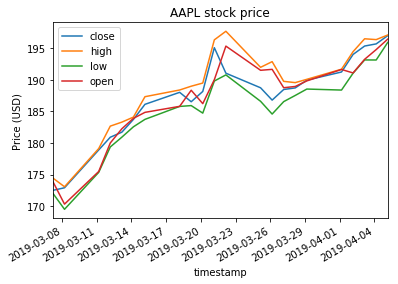

In [91]:
import matplotlib.pyplot as plt
dedup_df.plot(y=['close','high','low','open'], use_index=True)
plt.title('AAPL stock price')
plt.ylabel('Price (USD)')
plt.show()

It looks like over the past 30 days, Apple's stock has overall increased. 

From wikipedia, volume is commonly reported as the number of shares that changed hands during a given day. Let's check if the volume for Apple's stock has changed over time. 

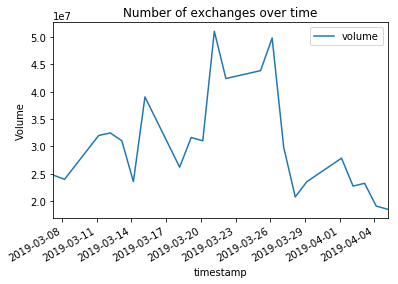

In [109]:
dedup_df.plot(y=['volume'], use_index=True)
plt.title('Number of exchanges over time')
plt.ylabel('Volume')
plt.show()

It looks like the volume has been changing quite a lot for the past 30 days. 
Let's see if there is any relationship between volume and Apple's stock. For that let's plot a correlation matrix.

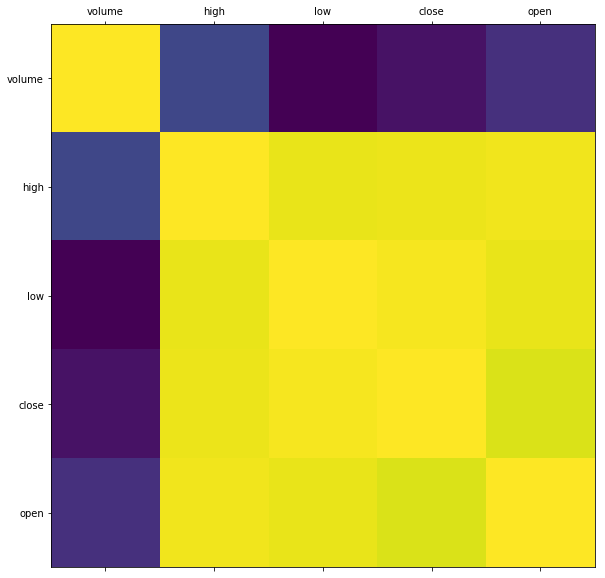

In [83]:
corr = dedup_df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

This correlation matrix shows that there doesn't seem to be a relationship between volume and stock price (close, high, open, and low).

Let's see if there is any relationship between the day of the week and Apple's stock prices.

In [135]:

week_df = dedup_df.copy(deep=True)
week_df['day_of_week'] = dedup_df.index.day_name()
week_df.head()

,volume,symbol,high,tradingDay,low,close,open,day_of_week
timestamp,,,,,,,,
2019-03-07 05:00:00+00:00,24796300,AAPL,174.44,2019-03-07,172.02,172.50,173.87,Thursday
2019-03-08 05:00:00+00:00,23999300,AAPL,173.07,2019-03-08,169.50,172.91,170.32,Friday
2019-03-11 04:00:00+00:00,32011000,AAPL,179.12,2019-03-11,175.35,178.90,175.49,Monday
2019-03-12 04:00:00+00:00,32467500,AAPL,182.67,2019-03-12,179.37,180.91,180.00,Tuesday
2019-03-13 04:00:00+00:00,31032500,AAPL,183.30,2019-03-13,180.92,181.71,182.25,Wednesday


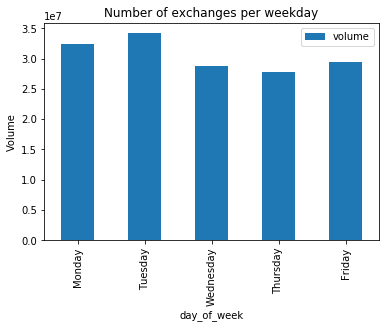

In [136]:

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
week_df = week_df.groupby(week_df.day_of_week).mean().reindex(days)
week_df.plot(y=['volume'],kind='bar')
plt.title('Number of exchanges per weekday')
plt.ylabel('Volume')
plt.show()

Based on this data, there doesn't seem to be a relationship between day of the week and the number of exchanges. 

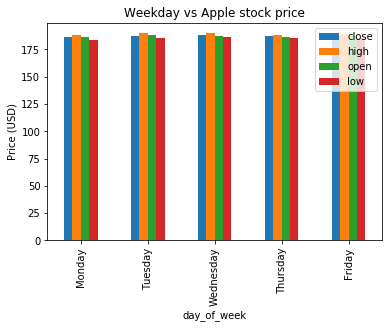

In [138]:
week_df.plot(y=['close','high','open','low'], kind='bar')
plt.title('Weekday vs Apple stock price')
plt.ylabel('Price (USD)')
plt.show()

The above chart shows that the stock price doesn't really change with the day of week. 

## Summary and Insights on stock data



### Data Audit: 
1. "openInterest" field was always None. 
2. There were a lot of duplicate data.
3. The data is not complete: some days are missing (in this case March 9th, 10th) 
4. The data is only updated at 4am and 5am. 
5. There are no data for weekends.

### Data Analysis:
1. Overall trend of Apple's stock over the last 30 days: we see an steady increase in Apple's stock prices.
2. The number of share exchanges (volume) fluctuates quite a bit over the past 30 days.
3. There doesn't seem to be a relationship between the number of share exchanges and the stock prices.
4. There doesn't seem to be a relationship betwee stock price and day of the week.\


### Notes:
It is important to note that more data needs to be analyzed in order to deduce better, more trustworthy insights. 